In [3]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

In [14]:
def sigmoid(z) :
    return 1 / (1 + np.exp(-z))

def sigmoid_cp(z) :
    return 1 / (1 + cp.exp(-z))

def forward(X, W1, b1, W2, b2) :
    Z = np.tanh(X.dot(W1) + b1)
    return sigmoid(Z.dot(W2) + b2), Z

def forward_cp(X, W1, b1, W2, b2) :
    Z = cp.tanh(X.dot(W1) + b1)
    return sigmoid(Z.dot(W2) + b2), Z

def predict(Y) :
    return np.round(Y)

def classification_rate(T, Y) :
    return np.mean(T == Y)

def derivate_w2(Z, T, Y) :
    return Z.T.dot(T - Y)

def derivate_b2(T, Y) :
    return (T - Y).sum(axis = 0)

def derivate_w1(X, T, Y, W2, Z) :
    return X.T.dot((T - Y).dot(W2.T) *(1 - Z * Z))

def derivate_w1_outer(X, T, Y, W2, Z) :
    #dz= np.outer(T - Y, W2) * Z * (1 - Z)
    dz = np.outer(T - Y, W2) * (1 - Z * Z)
    return X.T.dot(dz)

def derivate_w1_outer_cp(X, T, Y, W2, Z) :
    #dz= np.outer(T - Y, W2) * Z * (1 - Z)
    dz = cp.outer(T - Y, W2) * (1 - Z * Z)
    return X.T.dot(dz)

def derivate_b1(T, Y, W2, Z) :        
    return ((T - Y).dot(W2.T) * (1 - Z * Z)).sum(axis = 0)

def derivate_b1_outer(T, Y, W2, Z) :
    dz = np.outer(T - Y, W2) * (1 - Z * Z)
    return dz.sum(axis = 0)

def derivate_b1_outer_cp(T, Y, W2, Z) :
    dz = cp.outer(T - Y, W2) * (1 - Z * Z)
    return dz.sum(axis = 0)



def cross_entropy(T, Y) :
    E = 0
    for i in range(len(T)) :
        if T[i] == 1 :
            E += T[i] * np.log(Y[i])
        else :
            E += np.log(1 - Y[i])
    return E

def cross_entropy_cp(T, Y) :
    E = 0
    for i in range(len(T)) :
        if T[i] == 1 :
            E += T[i] * cp.log(Y[i])
        else :
            E += cp.log(1 - Y[i])
    return E

def cross_entropy_mean(T, Y) :
    return (T * (np.log(Y)) + (1 - T) * (np.log(1 - Y))).mean()

def cross_entropy_mean_cp(T, Y) :
    return (T * (cp.log(Y)) + (1 - T) * (cp.log(1 - Y))).mean()

def to_indicator(Y_in, K) :
    N = len(Y_in)
    Y_out = np.zeros((N, K))
    for i in range(N) :
        Y_out[i][Y_in[i]] = 1
    return Y_out

def to_indicator_cp(Y_in, K) :
    N = len(Y_in)
    Y_out = cp.zeros((N, K))
    for i in range(N) :
        Y_out[i][Y_in[i]] = 1
    return Y_out

In [15]:
def test_xor(ongpu = False) :
    #here K = 1 (since it is a binary classification), hence we need to do outer product in W1
    if ongpu == False: 
        X = np.array([[0 , 0], [0, 1], [1, 0], [1, 1] ])
        Y = np.array([0, 1, 1, 0])
        W1 = np.random.randn(2, 4) / np.sqrt(8)
        b1 = np.random.randn(4) / 2
        W2 = np.random.randn(4) / 2
        b2 = np.random.rand(1)
    else :
        X = cp.array([[0 , 0], [0, 1], [1, 0], [1, 1] ])
        Y = cp.array([0, 1, 1, 0])
        W1 = cp.random.randn(2, 4) / cp.sqrt(8)
        b1 = cp.random.randn(4) / 2
        W2 = cp.random.randn(4) / 2
        b2 = cp.random.rand(1)
    
    LL = []
    learning_rate = 0.01
    regularization = 0.
    last_ll_rate = None
    for i in range(30000) :
        if ongpu == False :
            pY, Z = forward(X, W1, b1, W2, b2)
#             ll = cross_entropy(Y, pY)
            ll = cross_entropy_mean(Y, pY)
            cl = classification_rate(Y, np.round(pY))
        else :
            pY, Z = forward_cp(X, W1, b1, W2, b2)
#             ll = cross_entropy_cp(Y, pY)
            ll = cross_entropy_mean_cp(Y, pY)
            cl = classification_rate(cp.asnumpy(Y),cp.asnumpy(cp.round(pY)))
            
        if ongpu == True :
            ll = ll.get()        
        LL.append(ll)
        if (cl == 1.0) :
            print('Early exit')
            break
        
        if ongpu == True :
            W1 += learning_rate * (derivate_w1_outer_cp(X, Y, pY, W2, Z) - regularization * W1)
            b1 += learning_rate * (derivate_b1_outer_cp(Y, pY, W2, Z) - regularization * b1)
        else :
            W1 += learning_rate * (derivate_w1_outer(X, Y, pY, W2, Z) - regularization * W1)
            b1 += learning_rate * (derivate_b1_outer(Y, pY, W2, Z) - regularization * b1)
            
        W2 += learning_rate * (derivate_w2(Z, Y, pY) - regularization * W2)
        b2 += learning_rate * (derivate_b2(Y, pY) - regularization * b2)
        if i % 1000 == 0 :
            print('Classification rate : ', cl)
            print('Log likelihood ', ll)
            print('pY ',pY)
            
    if ongpu == False :
        print('Final Classification rate : ', classification_rate(Y, np.round(pY)))
    else : 
        print('Final Classification rate : ', classification_rate(cp.asnumpy(Y), cp.asnumpy(cp.round(pY))))
    
    print('Classification rate : ', cl)
    print('Log likelihood ', ll)
    print('pY ',pY)
    plt.plot(LL)

In [26]:
def test_donut(ongpu = False) :
    radius1 = 5
    radius2 = 10
    N = 500
    M = 8
    K = 2
    
    if ongpu == False :
        theta1 = np.random.rand(N) * (2*np.pi)
        r1 = np.random.randn(N)  + radius1 
        x1 = r1 * np.cos(theta1)
        y1 = r1 * np.sin(theta1)
        
        theta2 = np.random.rand(N) * (2*np.pi)
        r2 = radius2 + np.random.randn(N)
        x2 = r2 * np.cos(theta2)
        y2 = r2 * np.sin(theta2)
        
        
        plt.scatter(x1, y1, s = 7)
        plt.scatter(x2, y2, s = 5)
        
        X1 = np.stack((x1, y1), axis = 1)
        X2 = np.stack((x2, y2), axis = 1)
        X = np.concatenate((X1, X2), axis = 0)
        Y = np.array([0] * N + [1] * N)
        Y_ind = to_indicator(Y, K)
        N, D = X.shape
        W1 = np.random.randn(D, M) / np.sqrt(D * M)
        b1 = np.random.randn(M) / np.sqrt(M)
        W2 = np.random.randn(M, K) / np.sqrt(M * K)
        b2 = np.random.randn(K)
        
    else :
        theta1 = cp.random.rand(N) * (2*cp.pi)
        r1 = cp.random.randn(N)  + radius1 
        x1 = r1 * cp.cos(theta1)
        y1 = r1 * cp.sin(theta1)
        
        theta2 = cp.random.rand(N) * (2*cp.pi)
        r2 = radius2 + cp.random.randn(N)
        x2 = r2 * cp.cos(theta2)
        y2 = r2 * cp.sin(theta2)
        
        
        plt.scatter(x1.get(), y1.get(), s = 7)
        plt.scatter(x2.get(), y2.get(), s = 5)
        
        X1 = cp.stack((x1, y1), axis = 1)
        X2 = cp.stack((x2, y2), axis = 1)
        X = cp.concatenate((X1, X2), axis = 0)
        Y = cp.array([0] * N + [1] * N)
        Y_ind = to_indicator_cp(Y, K)
        N, D = X.shape
        W1 = cp.random.randn(D, M) / cp.sqrt(D * M)
        b1 = cp.random.randn(M) / cp.sqrt(M)
        W2 = cp.random.randn(M, K) / cp.sqrt(M * K)
        b2 = cp.random.randn(K)
    
    LL = []
    learning_rate = 0.0001
    regularization = 0.2
    last_ll_rate = None
    for i in range(10000) :
        if ongpu == False :
            pY, Z = forward(X, W1, b1, W2, b2)
#             ll = cross_entropy(Y, pY)
            ll = cross_entropy_mean(Y_ind, pY)
            cl = classification_rate(Y_ind, np.round(pY))
        else :
            pY, Z = forward_cp(X, W1, b1, W2, b2)
#             ll = cross_entropy_cp(Y, pY)
            ll = cross_entropy_mean_cp(Y_ind, pY)
            cl = classification_rate(Y_ind.get(),np.round(pY.get()))
            
        if ongpu == True :
            ll = ll.get()        
        LL.append(ll)
        if (cl == 1.0) :
            print('Early exit')
            break
        
        W1 += learning_rate * (derivate_w1(X, Y_ind, pY, W2, Z) - regularization * W1)
        b1 += learning_rate * (derivate_b1(Y_ind, pY, W2, Z) - regularization * b1)
        W2 += learning_rate * (derivate_w2(Z,Y_ind, pY) - regularization * W2)
        b2 += learning_rate * (derivate_b2(Y_ind, pY) - regularization * b2)
        if i % 1000 == 0 :
            print('Classification rate : ', cl)
            print('Log likelihood ', ll)
            
    
    print('Classification rate : ', cl)
    print('Log likelihood ', ll)
    plt.figure()
    plt.plot(LL)
    plt.show()

Classification rate :  0.5
Log likelihood  -0.9245284985957613
Classification rate :  0.988
Log likelihood  -0.20012048180921
Classification rate :  0.991
Log likelihood  -0.11337967890525619
Classification rate :  0.994
Log likelihood  -0.08287097869412553
Classification rate :  0.994
Log likelihood  -0.06729975682830062
Classification rate :  0.996
Log likelihood  -0.05806592773437169
Classification rate :  0.996
Log likelihood  -0.05203946390433724
Classification rate :  0.996
Log likelihood  -0.047784721594409545
Classification rate :  0.996
Log likelihood  -0.04461286882060968
Classification rate :  0.997
Log likelihood  -0.04213651157174527
Classification rate :  0.996
Log likelihood  -0.04007736750639902


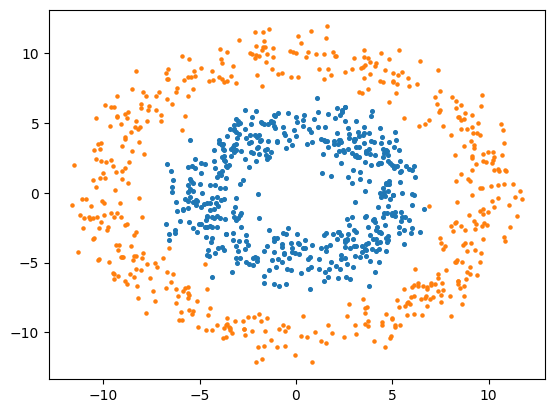

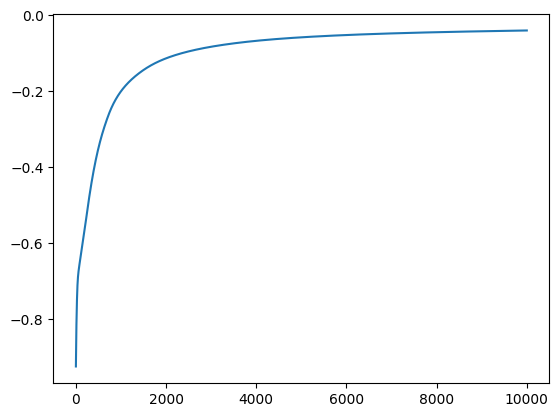

In [27]:
if __name__ == '__main__' :
#     test_xor(True)
    test_donut(True)

### Numpy outer() method

In [55]:
x = np.array([1, 2, 3])
y = np.linspace(2, 6, 3)
 
Output = np.outer(x, y)
 
print("Result : ",Output)

Result :  [[ 2.  4.  6.]
 [ 4.  8. 12.]
 [ 6. 12. 18.]]


In [56]:
arr1 = np.array([2, 6])
arr2 = np.array([5, 8])
 
print("Array1 : ",arr1)
print("Array2 : ",arr2)
 
output = np.outer(arr1, arr2)
print("Result : ",output)

Array1 :  [2 6]
Array2 :  [5 8]
Result :  [[10 16]
 [30 48]]


The input array will flatten if it is not 1 dimensional and then 
- no of rows in result  = no of elements in first array
- no of columns in result = no of elements in second array
- each row in result = each element in second array * first array element

In [61]:
arr1 = np.array([[2, 5], [3, 5]])
arr2 = np.array([[1, 2], [2, 6]])
 
print("Array1 : \n",arr1)
print("Array2 : \n",arr2)
 
output = np.outer(arr1, arr2)
print("Result : \n",output)
arr1.flatten() * arr2.flatten()

Array1 : 
 [[2 5]
 [3 5]]
Array2 : 
 [[1 2]
 [2 6]]
Result : 
 [[ 2  4  4 12]
 [ 5 10 10 30]
 [ 3  6  6 18]
 [ 5 10 10 30]]


array([ 2, 10,  6, 30])

In [73]:
np.random.randn(10, 1).T.shape

(1, 10)

In [15]:
(np.random.rand(100) * (2*np.pi))

array([2.06551723, 1.09327137, 3.23386324, 3.84496862, 1.81674342,
       3.03396306, 4.95091482, 1.37684035, 3.1595401 , 0.87429378,
       0.28248931, 0.13896237, 5.09965393, 5.75450824, 2.87979332,
       1.91472059, 5.84836752, 0.46114401, 4.0901854 , 5.73454476,
       5.65539606, 4.64782593, 4.93185626, 3.3626373 , 1.7993358 ,
       3.00965328, 1.3607354 , 2.19190516, 5.02512624, 1.45328442,
       2.50013994, 0.8058479 , 4.30714011, 3.17811559, 5.40118179,
       0.24528348, 1.97239634, 6.24090655, 4.27268296, 6.26417568,
       4.74988009, 0.08561863, 0.4955373 , 0.26524724, 1.28455211,
       0.37887474, 5.69097497, 4.6959199 , 3.19390472, 6.03821112,
       3.4643952 , 1.15251452, 0.80365027, 4.10301879, 6.24101983,
       2.79023222, 1.85339559, 4.92245416, 3.31802399, 5.11042693,
       5.77553842, 4.95400236, 4.76133655, 0.74456963, 2.24001307,
       3.14525766, 1.14090366, 2.2823209 , 1.42470213, 3.52115732,
       4.44460437, 4.6230006 , 1.59734745, 5.5764156 , 6.06509

In [21]:
x = cp.zeros(10)
y = cp.ones(10)
z = cp.stack((x,y), axis = 1)
z

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])